Four Node Maxcut Graph with solutions of "0101" and "1010".

1. "0" is red.
2. "1" is blue.

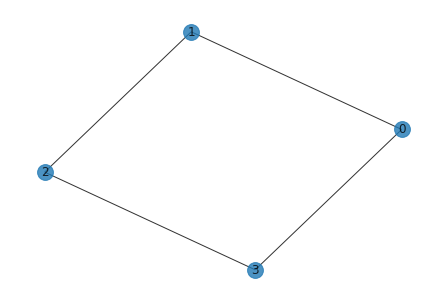

In [1]:
import networkx as nx
import matplotlib.pyplot as plt


G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=250)

# Maxcut 1 Loop
0. Create QAOA Circuit
1. Initialize Betta and Gamma parameters.
2. Transpile with Qiskit
3. Save OpenQASM3 file
4. Execute Circuit on fake backend to get measurement results. 
5. Compute expectation value using the measurement results.
6. Use Classical Optimizer to find new set of parameters using classical optimization algorithm
7. Create new OpenQASM3 file with new set of parameters.




### Step 0) Create QAOA circuit

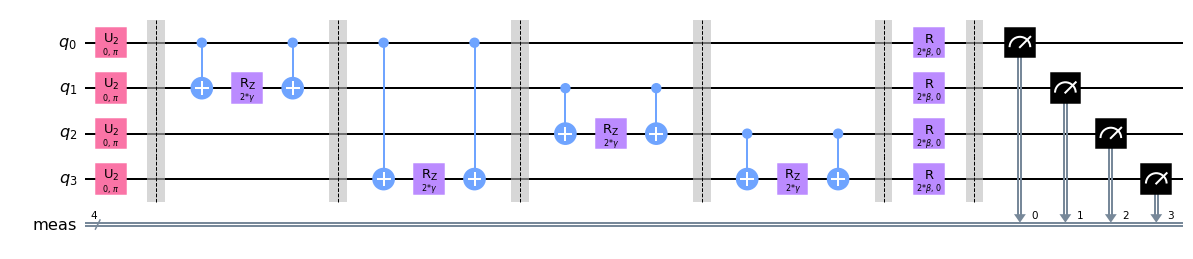

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    qc.barrier()
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])
            qc.barrier()

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

gamma = Parameter("$\\gamma$")
beta = Parameter("$\\beta$")

qc_res = create_qaoa_circ(G, [beta, gamma])
qc_res.decompose().draw("mpl")

### Step 1) Initialize Beta and Gamma Parameters

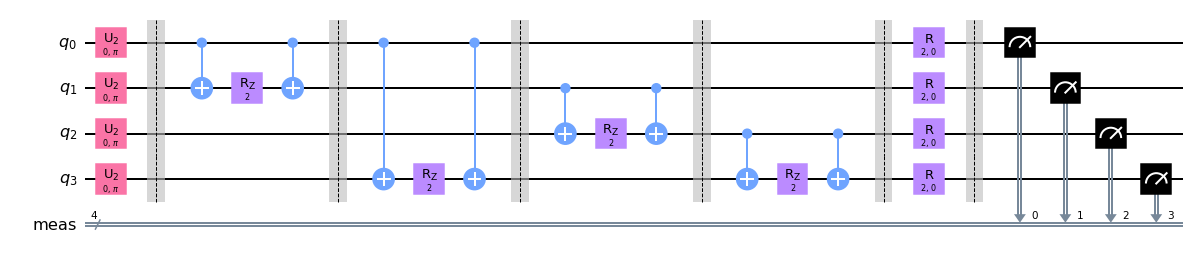

In [3]:
qc_res = create_qaoa_circ(G, [1.0, 1.0])
qc_res.decompose().draw("mpl")

### Step 2) Transpile with Qiskit

In [4]:
#from qiskit import transpile
#from qiskit.test.mock import FakeBoeblingen

#backend = FakeBoeblingen()
    
#qc_basis = transpile(qc_res, backend, optimization_level=3)
#qc_basis.draw(output='mpl')

### Step 3) Save OpenQASM3 file

In [5]:
# Qiskit Circuit  <-->  .qasm file
from qiskit import qasm3

# Qiskit -> OpenQASM3
# Print
print(qasm3.dumps(qc_res))
# Dump to file
with open("MaxCut_newparam0_untranspiled_qc0_SC.qasm", 'w+') as fp:
    qasm3.dump(qc_res, fp)

OPENQASM 3;
include "stdgates.inc";
gate rzz_140490701410512(_gate_p_0) _gate_q_0, _gate_q_1 {
  cx _gate_q_0, _gate_q_1;
  rz(2) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
}
gate rzz_140490701410656(_gate_p_0) _gate_q_0, _gate_q_1 {
  cx _gate_q_0, _gate_q_1;
  rz(2) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
}
gate rzz_140490701410416(_gate_p_0) _gate_q_0, _gate_q_1 {
  cx _gate_q_0, _gate_q_1;
  rz(2) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
}
gate rzz_140490701410464(_gate_p_0) _gate_q_0, _gate_q_1 {
  cx _gate_q_0, _gate_q_1;
  rz(2) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
}
bit[4] meas;
qubit[4] _all_qubits;
let q = _all_qubits[0:3];
h q[0];
h q[1];
h q[2];
h q[3];
barrier q[0], q[1], q[2], q[3];
rzz_140490701410512(2) q[0], q[1];
barrier q[0], q[1], q[2], q[3];
rzz_140490701410656(2) q[0], q[3];
barrier q[0], q[1], q[2], q[3];
rzz_140490701410416(2) q[1], q[2];
barrier q[0], q[1], q[2], q[3];
rzz_140490701410464(2) q[2], q[3];
barrier q[0], q[1], q[2], q[3];
rx(2) q[0];
rx(2) q[1];
rx(2) q[2];

### Step 4)  Execute Circuit on fake backend to get measurement results. 


In [6]:
# A function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

### Step 5) Compute expectation value using the measurement results.


In [7]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj

def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

### Step 6) Use Classical Optimizer to find new set of parameters using classical optimization algorithm


In [8]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

# method = 'COBYLA' is the classical optimizer method
res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')

new_parameters = res.x
print(res, "\n")
print("New Beta: ", res.x[0], "\nNew Gamma: ", res.x[1])

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483]) 

New Beta:  1.9793336987050993 
New Gamma:  1.1666348296094806


### Step 7) Create new OpenQASM3 file with new set of parameters.

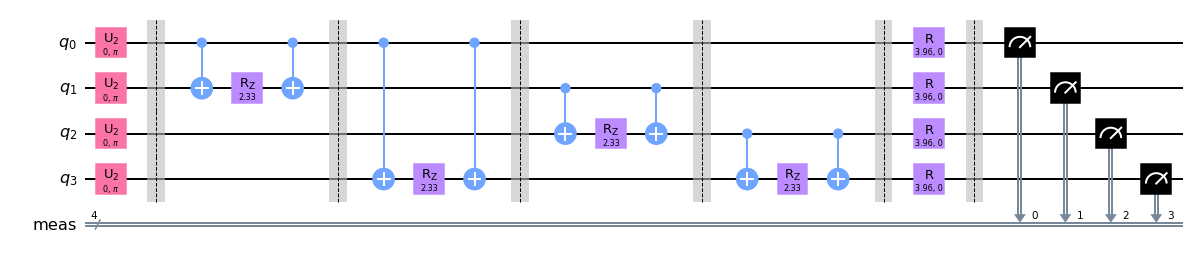

In [9]:
qc_res = create_qaoa_circ(G, res.x)
qc_res.decompose().draw('mpl')

In [10]:
# Qiskit Circuit  <-->  .qasm file
from qiskit import qasm3

# Qiskit -> OpenQASM3
# Print
print(qasm3.dumps(qc_res))
# Dump to file
with open("MaxCut_newparam1_untranspiled_qc0_SC.qasm", 'w+') as fp:
    qasm3.dump(qc_res, fp)

OPENQASM 3;
include "stdgates.inc";
gate rzz_140490748835824(_gate_p_0) _gate_q_0, _gate_q_1 {
  cx _gate_q_0, _gate_q_1;
  rz(2.3333) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
}
gate rzz_140490748834432(_gate_p_0) _gate_q_0, _gate_q_1 {
  cx _gate_q_0, _gate_q_1;
  rz(2.3333) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
}
gate rzz_140490748837696(_gate_p_0) _gate_q_0, _gate_q_1 {
  cx _gate_q_0, _gate_q_1;
  rz(2.3333) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
}
gate rzz_140490748834192(_gate_p_0) _gate_q_0, _gate_q_1 {
  cx _gate_q_0, _gate_q_1;
  rz(2.3333) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
}
bit[4] meas;
qubit[4] _all_qubits;
let q = _all_qubits[0:3];
h q[0];
h q[1];
h q[2];
h q[3];
barrier q[0], q[1], q[2], q[3];
rzz_140490748835824(2.3333) q[0], q[1];
barrier q[0], q[1], q[2], q[3];
rzz_140490748834432(2.3333) q[0], q[3];
barrier q[0], q[1], q[2], q[3];
rzz_140490748837696(2.3333) q[1], q[2];
barrier q[0], q[1], q[2], q[3];
rzz_140490748834192(2.3333) q[2], q[3];
barrier q[0], q[1], q[2], q

In [11]:
from qiskit.test.mock import FakeMelbourneV2
from qiskit.compiler import transpile

simulated_backend = FakeMelbourneV2()
transpiled_qc = transpile(qc_res, simulated_backend, optimization_level=3)

In [12]:
transpiled_qc.draw()

global phase: π
                                                                             »
  ancilla_0 -> 0 ────────────────────────────────────────────────────────────»
                                                                             »
  ancilla_1 -> 1 ────────────────────────────────────────────────────────────»
                                                                             »
  ancilla_2 -> 2 ────────────────────────────────────────────────────────────»
                 ┌─────────┐┌────┐┌─────────┐ ░ ┌───┐┌──────────────────────┐»
        q_1 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤ X ├┤ Rz(2.33326965921896) ├»
                 ├─────────┤├────┤├─────────┤ ░ └─┬─┘└──────────────────────┘»
        q_0 -> 4 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░───■──────────────────────────»
                 └─────────┘└────┘└─────────┘ ░                              »
  ancilla_3 -> 5 ────────────────────────────────────────────────────────────»
                                                                             »
  ancilla_4 -> 6 ────────────────────────────────────────────────────────────»
                                                                             »
  ancilla_5 -> 7 ────────────────────────────────────────────────────────────»
                                                                             »
  ancilla_6 -> 8 ────────────────────────────────────────────────────────────»
                                                                             »
  ancilla_7 -> 9 ────────────────────────────────────────────────────────────»
                 ┌─────────┐┌────┐┌─────────┐ ░                              »
       q_3 -> 10 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░──────────────────────────────»
                 ├─────────┤├────┤├─────────┤ ░                              »
       q_2 -> 11 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░──────────────────────────────»
                 └─────────┘└────┘└─────────┘ ░                              »
 ancilla_8 -> 12 ────────────────────────────────────────────────────────────»
                                                                             »
 ancilla_9 -> 13 ────────────────────────────────────────────────────────────»
                                                                             »
ancilla_10 -> 14 ────────────────────────────────────────────────────────────»
                                                                             »
         meas: 4/════════════════════════════════════════════════════════════»
                                                                             »
«                                                                   »
«  ancilla_0 -> 0 ──────────────────────────────────────────────────»
«                                                                   »
«  ancilla_1 -> 1 ──────────────────────────────────────────────────»
«                                                                   »
«  ancilla_2 -> 2 ──────────────────────────────────────────────────»
«                 ┌───┐ ░                                    ░      »
«        q_1 -> 3 ┤ X ├─░────────────────────────────────────░───■──»
«                 └─┬─┘ ░                                    ░   │  »
«        q_0 -> 4 ──■───░───■────────────────────────────■───░───┼──»
«                       ░   │                            │   ░   │  »
«  ancilla_3 -> 5 ──────────┼────────────────────────────┼───────┼──»
«                           │                            │       │  »
«  ancilla_4 -> 6 ──────────┼────────────────────────────┼───────┼──»
«                           │                            │       │  »
«  ancilla_5 -> 7 ──────────┼────────────────────────────┼───────┼──»
«                           │                            │       │  »
«  ancilla_6 -> 8 ──────────┼────────────────────────────┼───────┼──»
«                           │                            │       │  »
«  ancilla_7 -> 9 ──────────┼──────────────────

In [13]:
# Transpiled Level 3 initial value OpenQASM3
print(qasm3.dumps(transpiled_qc))

OPENQASM 3;
include "stdgates.inc";
bit[4] meas;
rz(pi/2) $3;
sx $3;
rz(pi/2) $3;
rz(pi/2) $4;
sx $4;
rz(pi/2) $4;
rz(pi/2) $10;
sx $10;
rz(pi/2) $10;
rz(pi/2) $11;
sx $11;
rz(pi/2) $11;
barrier $4, $3, $11, $10;
cx $4, $3;
rz(2.33326965921896) $3;
cx $4, $3;
barrier $4, $3, $11, $10;
cx $4, $10;
rz(2.33326965921896) $10;
cx $4, $10;
barrier $4, $3, $11, $10;
cx $3, $11;
rz(2.33326965921896) $11;
cx $3, $11;
barrier $4, $3, $11, $10;
cx $11, $10;
rz(2.33326965921896) $10;
cx $11, $10;
barrier $4, $3, $11, $10;
rz(pi/2) $10;
sx $10;
rz(7.10026005099999) $10;
sx $10;
rz(5*pi/2) $10;
rz(pi/2) $11;
sx $11;
rz(7.10026005099999) $11;
sx $11;
rz(5*pi/2) $11;
rz(pi/2) $3;
sx $3;
rz(7.10026005099999) $3;
sx $3;
rz(5*pi/2) $3;
rz(pi/2) $4;
sx $4;
rz(7.10026005099999) $4;
sx $4;
rz(5*pi/2) $4;
barrier $4, $3, $11, $10;
meas[0] = measure $4;
meas[1] = measure $3;
meas[2] = measure $11;
meas[3] = measure $10;



In [15]:
# Then run for the initial values ang get the expectation values.
# Put (maxiter=1) while running!

<>:11: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
<>:11: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
/var/folders/sz/0cdcg0js763gfjpq1kj566p00000gn/T/ipykernel_73488/547358479.py:11: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  method='COBYLA'(maxiter=80))
/var/folders/sz/0cdcg0js763gfjpq1kj566p00000gn/T/ipykernel_73488/547358479.py:11: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  method='COBYLA'(maxiter=80))
/var/folders/sz/0cdcg0js763gfjpq1kj566p00000gn/T/ipykernel_73488/547358479.py:11: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  method='COBYLA'(maxiter=80))
/var/folders/sz/0cdcg0js763gfjpq1kj566p00000gn/T/ipykernel_73488/547358479.py:11: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  method='COBYLA'(maxiter=80))


TypeError: 'str' object is not callable

# Miscellaneous: QAOA Circuit with Everything Else

In [ ]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [ ]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')

res

In [ ]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)